In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset, random_split
from torchvision.io import read_image
from tqdm import tqdm

In [3]:
NUM_WORKERS = 4
TRAIN_BATCH_SIZE = 16
TEST_BATCH_SIZE = 16
VAL_BATCH_SIZE = 16

DATA_DIR = "D:\project\dataset\Brain_Tumer\Data"

In [4]:
#Transform the data
train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(256, antialias=True),   # Resize to make constent shape
    transforms.RandomRotation(10),            # Rotate image for better learning
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  
    transforms.RandomHorizontalFlip(),        # Flips for better learning, creating different types of images
    transforms.RandomVerticalFlip(),
    ])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(256, antialias=True),
    transforms.RandomRotation(10)
    ])

full_dataset = datasets.ImageFolder(root=DATA_DIR,
                          transform=test_transform)

## Split dataset into Train, Validation and Test Sets
test_dataset, validation_dataset, train_dataset = random_split(full_dataset, [0.1, 0.2, 0.7])


# prepare data loaders with batch sizes
train_loader = DataLoader(train_dataset, batch_size=TRAIN_BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=True)

val_loader = DataLoader(validation_dataset, batch_size=VAL_BATCH_SIZE, num_workers=NUM_WORKERS)
val_loader1 = DataLoader(validation_dataset, num_workers=NUM_WORKERS)

test_loader = DataLoader(test_dataset, batch_size=TEST_BATCH_SIZE, num_workers=NUM_WORKERS)
test_loader1 = DataLoader(test_dataset, num_workers=NUM_WORKERS)  # Full test data

In [5]:
class_to_idx = full_dataset.class_to_idx
idx_to_class = {idx : label for label, idx in full_dataset.class_to_idx.items()}

idx_to_class

{0: 'glioma_tumor', 1: 'meningioma_tumor', 2: 'normal', 3: 'pituitary_tumor'}

In [8]:
for _, image in train_dataset:
    print(_)
    break

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])


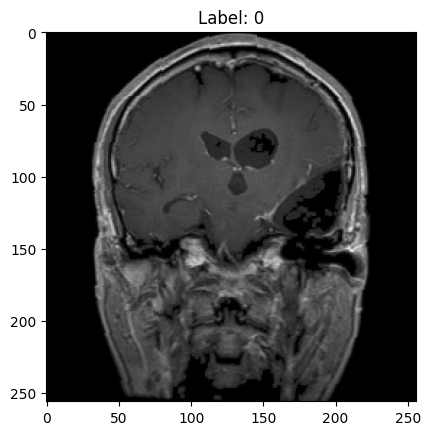

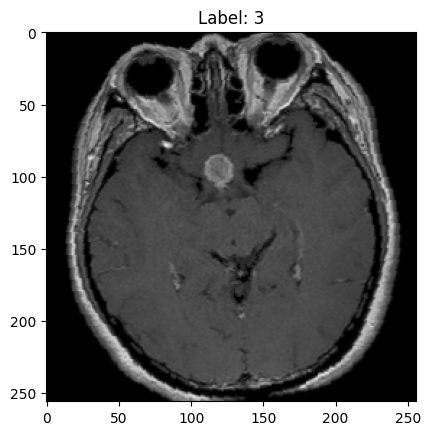

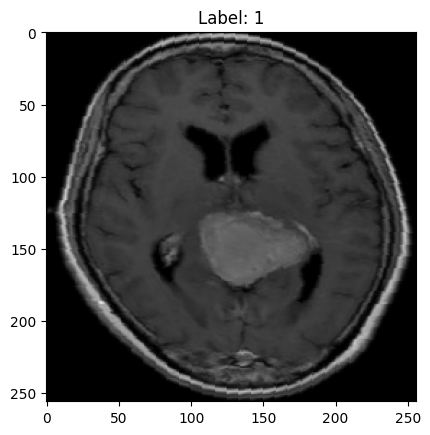

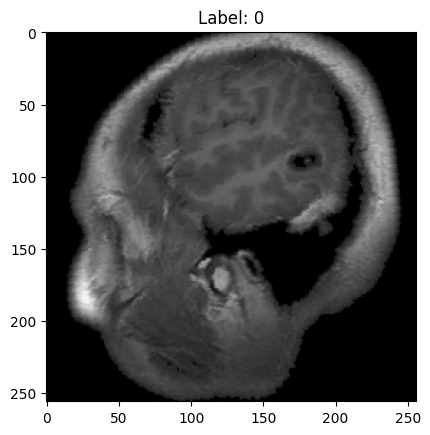

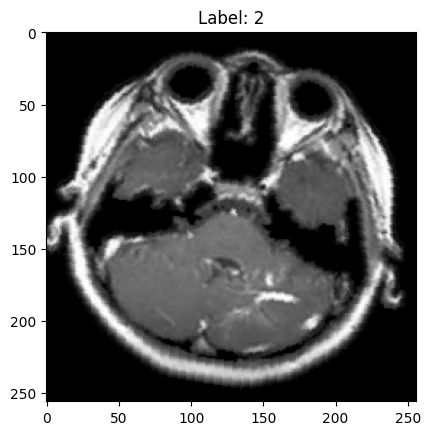

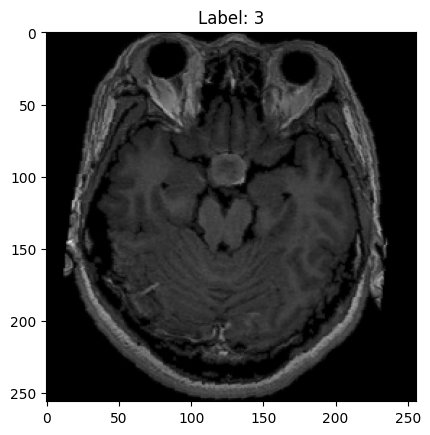

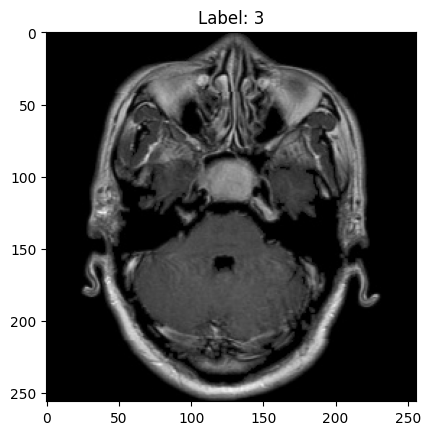

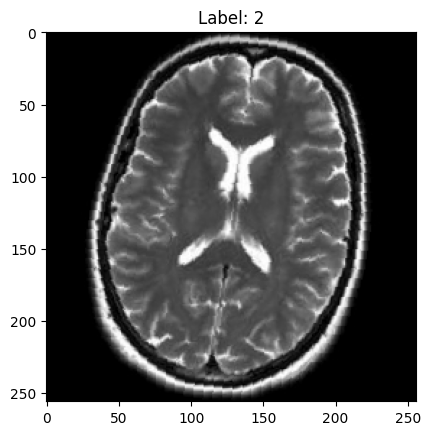

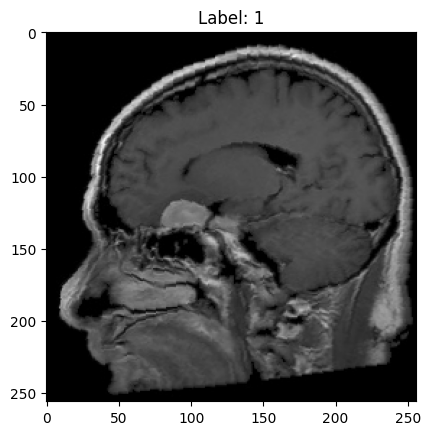

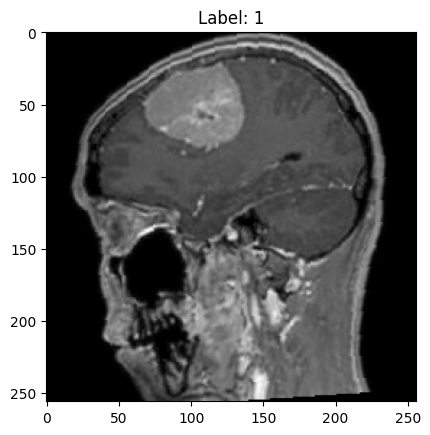

In [7]:
import matplotlib.pyplot as plt

for i in range(10):
  plt.imshow(train_loader.dataset[i][0].permute(1, 2, 0))
  plt.title(f"Label: {train_loader.dataset[i][1]}")
  plt.show()


In [22]:
class SpatialAttention(nn.Module):
  '''SpatialAttention class provides attention by retaining features from both maximum and mean 
  concatinates both outputs and convolved to retain the importent features'''
  def __init__(self):
    super(SpatialAttention, self).__init__()
    self.conv = nn.Conv2d(2, 1, kernel_size=7, padding=3)
    self.sigmoid = nn.Sigmoid()

  def forward(self, x):
    avg_out = torch.mean(x, dim=1, keepdim=True)
    max_out, _ = torch.max(x, dim=1, keepdim=True)
    x = torch.cat([avg_out, max_out], dim=1)
    x = self.conv(x)
    attention_map=self.sigmoid(x)
    return attention_map

class Classifier(nn.Module):
  '''Classifier class has CNN model to clasify image 
  this calles SpatialAttention class to receive attended '''
  def __init__(self, output_classes):
    super(Classifier, self).__init__()
    self.conv1=nn.Conv2d(3, 16,(3,3), padding=1)
    self.bn1=nn.BatchNorm2d(16)
    self.conv2=nn.Conv2d(16,32,(3,3), padding=1)
    self.bn2=nn.BatchNorm2d(32)
    self.conv3=nn.Conv2d(32,64,(3,3), padding=1)
    self.bn3=nn.BatchNorm2d(64)
    self.pool=nn.MaxPool2d((2,2))
    self.sa=SpatialAttention()
    conv_out_shape=256*256
    self.fc1=nn.Linear(conv_out_shape,256)
    self.fc1bn=nn.BatchNorm1d(256)
    self.fc2=nn.Linear(256,32)
    self.fc2bn=nn.BatchNorm1d(32)
    self.fc3=nn.Linear(32,output_classes)
    self.dropout=nn.Dropout(p=0.25, inplace=False)

  def forward(self, x):
    attn1=self.sa(x)   # adding spatial attention
    x=attn1*x
  
    x=self.pool(F.relu(self.conv1(x)))  #channels 3 -> 16
    x=self.bn1(x)     # batch normalization
    x=self.dropout(x) # dropout layer with probability=0.1

    attn2=self.sa(x)   # adding spatial attention
    x=attn2*x

    x=self.pool(F.relu(self.conv2(x)))  #channels 16 -> 32
    x=self.bn2(x)
    x=self.dropout(x)

    attn3=self.sa(x)   # adding spatial attention
    x=attn3*x

    x=self.pool(F.relu(self.conv3(x)))  #channels 32 -> 64
    x=self.bn3(x)
    x=self.dropout(x)

    x=torch.flatten(x, 1) #flatteten the final features in all channels to input into dense layer

    # Dense layer with batch normalization and dropouts
    x=F.relu(self.fc1(x))  # Hidden layer 1 number of nodes = 16
    x=self.fc1bn(x)
    x=self.dropout(x)

    x=F.relu(self.fc2(x))  # Hidden layer 2 number of nodes = 8
    x=self.fc2bn(x)
    x=self.dropout(x)

    x=self.fc3(x)          # output layer number of output classes = 4
    return x, [attn1, attn2, attn3]

model=Classifier(output_classes=4)

In [23]:
def print_initialized_parameters(model):
    for name, param in model.named_parameters():
        if param.requires_grad:
            print(f"Parameter name: {name}")
            print(param.data)

# Print the initialized values
print_initialized_parameters(model)

Parameter name: conv1.weight
tensor([[[[ 0.1362,  0.1222, -0.0861],
          [-0.1451, -0.1887, -0.0594],
          [-0.0641, -0.1023,  0.1080]],

         [[ 0.0195, -0.1834, -0.1582],
          [-0.0586, -0.0198, -0.0646],
          [ 0.1063,  0.0592,  0.1409]],

         [[ 0.0452,  0.1281, -0.0907],
          [ 0.1574, -0.1709,  0.0276],
          [ 0.0962, -0.1218,  0.1078]]],


        [[[-0.1105,  0.0709,  0.0551],
          [ 0.0767,  0.0020, -0.0319],
          [-0.0940, -0.1723,  0.1717]],

         [[ 0.1559, -0.0463,  0.0939],
          [-0.1787,  0.0823, -0.0205],
          [-0.1008, -0.0584, -0.0398]],

         [[-0.1090,  0.0986, -0.0221],
          [-0.0723,  0.0372, -0.1354],
          [-0.1424,  0.1439,  0.0383]]],


        [[[-0.0427, -0.0571,  0.1185],
          [-0.1262,  0.0619,  0.1598],
          [ 0.1734,  0.0106,  0.1712]],

         [[ 0.1878,  0.1222, -0.1443],
          [ 0.0740, -0.0135, -0.1900],
          [-0.0982, -0.1801,  0.0104]],

         [[ 0.0

In [ ]:
#manual intialization of parametes as per He initialization (best for relu)
'''
  def initialize_weights(self):
    for layers in self.modules():
      if isinstance (layers, nn.Linear):
        fan_in= layers.weight.data.size(1)
        nn.init.normal_(layers.weight(), mean=0.0, std=torch.sqrt(2.0/fan_in))

#auto intialization of parametes as per He initialization (best for relu)

  def initialize_weights(self):
    nn.init.kaiming_normal_(self.fc1.weight, nonlinearity='relu')
    nn.init.kaiming_normal_(self.fc2.weight, nonlinearity='relu')
    '''

In [47]:
import matplotlib.pyplot as plt
import os
'''
def save_attention_maps(images, attention_maps, epoch, phase, save_dir='attention_maps'):
    os.makedirs(save_dir, exist_ok=True)
    for i in range(len(images)):
        img = images[i].cpu().numpy().transpose((1, 2, 0))
        for j, attn in enumerate(attention_maps):
            attn_map = attn[i].cpu().numpy().squeeze()
            fig, ax = plt.subplots(1, 2, figsize=(10, 5))
            ax[0].imshow(img)
            ax[0].set_title('Original Image')
            ax[1].imshow(attn_map, cmap='jet', alpha=0.5)
            ax[1].set_title(f'Attention Map {j+1}')
            plt.savefig(os.path.join(save_dir, f'{phase}_epoch{epoch}_img{i}_attn{j+1}.png'))
            plt.close()'''

def save_attention_maps(images, labels, attention_maps, epoch, phase, save_dir='attention_maps'):
    os.makedirs(save_dir, exist_ok=True)
    for i in range(len(images)):
        img = images[i].cpu().numpy().transpose((1, 2, 0))
        label = labels[i].item()
        fig, axes = plt.subplots(1, 5, figsize=(20, 5))
        
        axes[0].imshow(img)
        axes[0].set_title(f'Original Image\nLabel: {label}')
        
        for j, attn in enumerate(attention_maps):
            attn_map = attn[i].cpu().numpy().squeeze()
            axes[j + 1].imshow(attn_map, cmap='jet', alpha=0.5)
            axes[j + 1].set_title(f'Attention Map {j + 1}')
        
        plt.savefig(os.path.join(save_dir, f'{phase}_epoch{epoch}_img{i}.png'))
        plt.close()

In [9]:
if torch.cuda.is_available(): 
    model = model.to('cuda')    #transfer model to GPU
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [10]:
criterion=nn.CrossEntropyLoss()   #criterion as cross entropy loss
optimizer=optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)   # Adam optimizer with a l2 regularization of lamda = 10^-4
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.01)   #learning rate decay with a factor of 0.01 per each 10 steps

In [11]:
# number of parameters in each layer

def print_num_params(model):
  for name, module in model.named_children():
    print(f"{name}: {sum(p.numel() for p in module.parameters())}")

print_num_params(model)


conv1: 448
bn1: 32
conv2: 4640
bn2: 64
conv3: 18496
bn3: 128
pool: 0
sa: 99
fc1: 16777472
fc1bn: 512
fc2: 8224
fc2bn: 64
fc3: 132
dropout: 0


In [13]:
x=model.parameters()
    

<generator object Module.parameters at 0x000001FB751E3CA0>


In [54]:
best_val_accuracy = 0
patience = 5
counter = 0
num_epochs = 40
best_model_state = None
val_accuracy=[0]
train_accuracy=[0]

for epoch in range(num_epochs):
  model.train()
  # Training loop
  for images, labels in tqdm(train_loader):
    if torch.cuda.is_available(): 
      images, labels = images.to(device), labels.to(device)    # transfer to GPU
    # Forward pass
    outputs, _ = model(images)
    loss = criterion(outputs, labels)

    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  scheduler.step()

  # Calculate train accuracy
  model.eval()
  correct = 0
  total = 0
  with torch.no_grad():
    for images, labels in train_loader:
      if torch.cuda.is_available(): 
        images, labels = images.to(device), labels.to(device)
      outputs, _ = model(images)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

  accuracy1 = 100 * correct / total
  train_accuracy.append(int(accuracy1))
  print(f'Epoch: {epoch+1}/{num_epochs}, training Accuracy: {accuracy1:.2f}%')

  # Calculate validation accuracy and save attention maps
  model.eval()
  correct = 0
  total = 0
  with torch.no_grad():
    for images, labels in val_loader1:
      if torch.cuda.is_available(): 
        images, labels = images.to(device), labels.to(device)
      outputs, attn = model(images)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
      
  accuracy2 = 100 * correct / total
  val_accuracy.append(int(accuracy2))
  print(f'Epoch: {epoch+1}/{num_epochs}, validation Accuracy: {accuracy2:.2f}%')

  # Save attention maps
  '''model.eval()
  with torch.no_grad():
    for images, labels in val_loader:
      if torch.cuda.is_available(): 
        images, labels = images.to(device), labels.to(device)
      outputs, attn = model(images)
      _, predicted = torch.max(outputs.data, 1)
      
      save_attention_maps(images, labels, attn, epoch, phase='val')'''

  if accuracy2 > best_val_accuracy:
    best_val_accuracy = accuracy2
    best_model_state = model.state_dict()  # saving best model parameters
    counter = 0
  else:
    counter += 1

  if counter >= patience:
    print("Early stopping")
    break

# loading best model parameters
if best_model_state is not None:
    model.load_state_dict(best_model_state)

# Calculate final test accuracy and save attention maps
model.eval()
correct = 0
total = 0
with torch.no_grad():
  for images, labels in test_loader1:
    if torch.cuda.is_available(): 
      images, labels = images.to(device), labels.to(device)
    outputs, attn = model(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
    
    # Save attention maps
    save_attention_maps(images, labels, attn, epoch, phase='test')

accuracy = 100 * correct / total
print(f'Test Accuracy: {accuracy:.2f}%')



  0%|          | 0/68 [00:00<?, ?it/s]

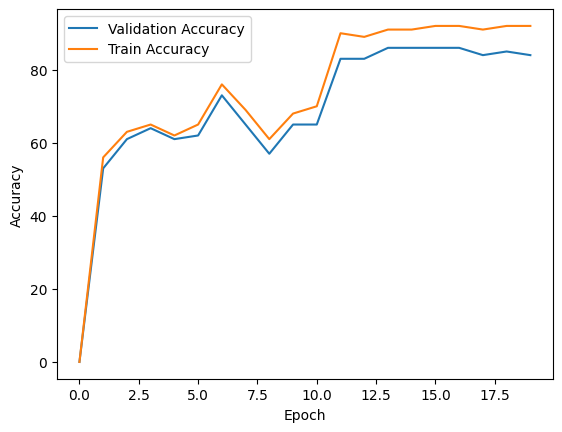

In [18]:
import matplotlib.pyplot as plt
#plot of accuracy graphs along whith number of epochs
plt.plot(val_accuracy, label='Validation Accuracy')
plt.plot(train_accuracy, label='Train Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [19]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
  for images, labels in test_loader1:
    if torch.cuda.is_available(): 
      images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'final Test Accuracy: {accuracy:.2f}%')

final Test Accuracy: 84.52%


In [20]:
from sklearn.metrics import confusion_matrix

# Get predicted and actual labels
predicted_labels = []
actual_labels = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader1:
        if torch.cuda.is_available(): 
            images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        predicted_labels.extend(predicted.tolist())
        actual_labels.extend(labels.tolist())

# Create confusion matrix
cm = confusion_matrix(actual_labels, predicted_labels)

# Print confusion matrix
print(cm)

[[77 14  2  0]
 [11 63  3  2]
 [ 2  3 38  0]
 [ 4  5  2 84]]


In [21]:
from sklearn.metrics import f1_score, precision_score, recall_score

# Calculate f1 score, precision and recall
f1 = f1_score(actual_labels, predicted_labels, average='weighted')
precision = precision_score(actual_labels, predicted_labels, average='weighted')
recall = recall_score(actual_labels, predicted_labels, average='weighted')

# Print results
print(f"F1 Score: {f1:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")


F1 Score: 0.85
Precision: 0.85
Recall: 0.85
